# Generanting SHAP Smaps and tree plots

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from MolMM import *

import pandas as pd
import numpy as np
import pickle
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from copy import deepcopy


import matplotlib as mpl
import matplotlib.font_manager as font_manager
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
from collections import defaultdict
from torch.utils.data.dataset import ConcatDataset,Subset
import shap

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

cpu = torch.device("cpu")
shap.initjs()
warnings.filterwarnings('ignore')

[1]


/home/ouyang/miniconda3/envs/SJJ/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = 'ckpt'
ckpt_dict = defaultdict(str)
for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if ('checkpoints' in dirpath and 'result' in dirpath):
            pathlist=os.path.join(dirpath, filename).split('/')
            ckpt_dict[pathlist[1]+'/'+pathlist[2]+'/'+pathlist[3]] = os.path.join(dirpath, filename)


def get_model(task,name,task_list):
    args = {}
    args['dir'] = './results/'+task
    args['ckpt_dir_1'] = './ckpt/'+task
    args['name'] = name
    args['task_list'] = task_list
    args['bar']=False
    args['allo']=True
    return get_models(args)

## Calculating SHAP value for the 2D input
* *tab2image* function map 1D tabular molecular descriptors into 2D Fmaps, achieve a bijection function between 1D and 2D features.
* The jection information is saved in document

In [3]:
with open('./params/indices_list.pkl', 'rb') as f:
    indices_list = pickle.load(f)

def tab2image(x):
    x = x.view(x.shape[0],-1)
    arr_res = []
    for idict in indices_list:
        indices = idict['indices']
        # idx = idict['idx']
        arr_1d = torch.zeros((x.shape[0],37*37),device=x.device)
        arr_1d[:,indices] = x[:,indices]
        arr_res.append(arr_1d.view(x.shape[0],1,37,37))
    x = torch.cat(arr_res, axis=1)
    return x

class LeNet_SHAP(LeNet_single):
    def __init__(self,task_list=[],N_way=None):
        super(LeNet_SHAP, self).__init__(task_list=task_list,N_way=N_way)
        with open('./params/indices_list.pkl', 'rb') as f:
            self.indices_list = pickle.load(f)
        self.relu_shap1=nn.ReLU()
        self.relu_shap2=nn.ReLU()
            
    def tab2image(self,x):
        x = x.view(x.shape[0],-1)
        arr_res = []
        for idict in self.indices_list:
            indices = idict['indices']
            arr_1d = torch.zeros((x.shape[0],37*37),device=x.device)
            arr_1d[:,indices] = x[:,indices]
            arr_res.append(arr_1d.view(x.shape[0],1,37,37))
        x = torch.cat(arr_res, axis=1)
        return x
        
    def forward(self, x):
        x = self.tab2image(x)
        x = self.relu_shap1(self.shared_layers(x))
        task=self.task_list[0]
        x = self.relu_shap2(self.output[task](x))
        results=self.lst[task](x)
        return (results[:,1]-results[:,0]).unsqueeze(-1)
    
# class DNN_SHAP(DNN_single):
#     def __init__(self, task_list=[]):
#         super(DNN_SHAP, self).__init__(task_list=task_list)
        
#     def forward(self,x):
#         x = self.shared_layers(x)
#         task = self.task_list[0]
#         prob = self.lst[task](F.relu(self.output[task](x)))
#         return prob

In [4]:
from pytorch_lightning.utilities import CombinedLoader

def get_dataset(dataset):
    if isinstance(dataset,ConcatDataset):
        X = torch.concat([data[:][0] for data in dataset.datasets])
        y = torch.concat([data[:][1] for data in dataset.datasets])
    else:
        X,y = dataset[:][0],dataset[:][1]
    return X,y

def get_images(model,X_train,test_num,finetune_inh,clustering):
    device=torch.device("cuda")
    df = pd.read_csv('./params/molinfo.csv')
    indices = df['indices'].tolist()
    feat_name = df.iloc[:,0].tolist()
    
    X_train = X_train.sum(axis=1).unsqueeze(1)
    SHAP_model = LeNet_SHAP(finetune_inh.task_list,finetune_inh.N_way)
    SHAP_model.load_state_dict(finetune_inh.model.state_dict(),strict=False)
    
    X = X_train.to(device).view(X_train.shape[0],-1)
    SHAP_model.to(device)
    SHAP_model.eval()

    print(SHAP_model)
    
    test_images = X[:test_num,...]

    print('input',X.shape)
    e = shap.DeepExplainer(SHAP_model,X)
    shap_values = e.shap_values(test_images,check_additivity=False)
    base_values = np.repeat(e.expected_value,test_images.shape[0])
    
    shap_values=shap.Explanation(
        values=shap_values,
        data=test_images.cpu().view(test_images.shape[0],-1),
        base_values=base_values,
    )

    # def f(x):
    #     tmp = x.copy()
    #     tmp = torch.tensor(tmp,device=device)
    #     return SHAP_model(tmp)
    
    # masker = shap.maskers.Image("blur(1,1)", X[0].shape)
    # masker = shap.maskers.Image("inpaint_telea", X[0].shape)
    
    # e = shap.Explainer(f, masker)
    # shap_values = e(X, max_evals=10000, batch_size=50)

    # shap_values=shap.Explanation(
    #     values=shap_values.values,
    #     data=shap_values.data,
    #     base_values=shap_values.base_values,
    # )
    
    indices=np.zeros(len(feat_name),dtype=np.int_)
    with open('./params/indices_list.pkl', 'rb') as f:
        indices_list = pickle.load(f)
        
    for idict in indices_list:
        ind,idx = idict['indices'],idict['idx']
        indices[idx] = ind

    # print(shap_values.values.shape,shap_values.data.shape,shap_values.base_values.shape)
    shap_values.data=shap_values.data.reshape(shap_values.data.shape[0],-1)[:,indices]
    shap_values.values=shap_values.values.reshape(shap_values.values.shape[0],-1,shap_values.values.shape[-1])[:,indices,:]
    shap_values.feature_names = feat_name
    print(shap_values.values.shape,shap_values.data.shape,shap_values.base_values.shape)
    
    shap_values = shap_values[...,-1]

    return shap_values

In [5]:
df = pd.read_csv('./params/molinfo.csv')
feat_name = df.iloc[:,0].to_numpy()

attr=defaultdict(str)
order_feat=defaultdict(int)
for i in range(len(df)):
    a,b=df.iloc[i,0],df.iloc[i,3]
    attr[a]=b

for i,s in enumerate(feat_name):
    order_feat[s]=i

cor=[]
for i in range(len(df)):
    cor.append([df.iloc[i]['indices']//37,df.iloc[i]['indices']%37])
cor=np.array(cor)

attr_conv=defaultdict(list)
index_list=[]
index_list_sum=[]

def process(shap_values):
    eps=1e-6
    shap_values=deepcopy(shap_values)
    try:
        shap_values.data=shap_values.data.cpu().numpy()
    except:
        pass
    df=pd.read_csv('./params/scale_info.csv')
    mx_scale=df.iloc[:,1:]['max'].to_numpy()
    mi_scale=df.iloc[:,1:]['min'].to_numpy()
    shap_values.data=shap_values.data*(mx_scale-mi_scale)+mi_scale
       
    return shap_values

from scipy.stats import chi2
from scipy import stats
from scipy.stats import kendalltau,spearmanr
def calc_cor(shap):
    tmp=deepcopy(shap)
    X=process(tmp).data
    y=process(tmp).values
    feat_corr=defaultdict(int)
    feat_pvalue=defaultdict(int)
    cor_list=[]
    plist=[]
    for i in range(X.shape[1]):

        feat=shap.feature_names[i]
        X_ = X[:,i]
        y_ = y[:,i]

        ind = np.arange(X_.shape[0])
        if ((attr[feat] == 'Estate' and not feat.startswith('N')) or attr[feat] == 'MOE'):
            ind = np.where(abs(X_)>1e-4)[0]

        if len(ind)<50:
            strength,pvalue=0,0
        else:
            strength,pvalue=spearmanr(X[ind,i], y[ind,i])
        
        if not abs(strength)<=1.0:
            strength,pvalue=0,0
            
        cor_list.append(strength)
        feat_corr[feat]=strength
        feat_pvalue[feat]=pvalue
        
    return np.array(cor_list),feat_corr,feat_pvalue


def fun3(shap_sub,sel,is_process=False,is_mean=False,mode='max'):
    tmp1=deepcopy(shap_sub[0])
    
    ss=[]
    mean_values=0
    for s in sel:
        shap_sel=shap_sub[s]    
        mean_values+=abs(shap_sel.values).mean()
        cal=abs(shap_sel.values)/abs(shap_sel.values).mean()
        # cal=abs(shap_sel.values)
        ss.append(cal)
    mean_values/=len(sel)
    tmp=np.array(ss)
    
    try:
        if is_process:
            shap_sel=process(shap_sub)[sel]
        else:
            shap_sel=shap_sub[sel]
            
        tmp1.data=shap_sel.data.mean(axis=0)
        tmp1.base_values=shap_sel.base_values.mean()
    except:
        pass

    ind=np.argmax(abs(tmp),axis=0) if mode=='max' else np.argmin(abs(tmp),axis=0)

    tt=np.zeros(tmp.shape[1])
    if is_mean:
        tmp1.values=abs(shap_sub[sel].values).mean(axis=0)
    else:
        for i,idx in enumerate(ind):
            tt[i]=tmp[idx,i]
        # tmp1.values=tt
        tmp1.values=tt*mean_values
    
    return tmp1

In [6]:
df_dist=pd.read_csv('./params/dist_matrix.csv')
dist_orginal=df_dist.iloc[:,1:].to_numpy()

In [7]:
name= 'CNN_pH_nval'
name_list = name.split('_')
data_module = DataModule(name_list)
data_module.prepare_data()
test_data = data_module.X['competitive']
test_name = pd.read_csv(os.path.join('MolMM/','csv/data_extra','competitive'+'_clean.csv'))['drug'].to_numpy()

excluding inhibitors_refine from inhibitors_classes
inhibitors_classes's overlap  79 0.4438202247191011
inhibitors_classes's conflict  10 0.12658227848101267

excluding competitive from inhibitors_classes
inhibitors_classes's overlap  8 0.6153846153846154
inhibitors_classes's conflict  No label for conflict!

excluding substrates_refine from substrates_classes
substrates_classes's overlap  344 0.4858757062146893
substrates_classes's conflict  19 0.055232558139534885

excluding competitive from substrates_classes
substrates_classes's overlap  11 0.8461538461538461
substrates_classes's conflict  No label for conflict!

excluding substrates_refine from allocrites_classes
allocrites_classes's overlap  351 0.4957627118644068
allocrites_classes's conflict  25 0.07122507122507123

excluding competitive from allocrites_classes
allocrites_classes's overlap  12 0.9230769230769231
allocrites_classes's conflict  No label for conflict!

excluding inhibitors_refine from allocrites_classes
allocrites

In [8]:
if not os.path.exists('./params/SHAP_SUB.npz'):
    print('Calculating SHAP values')

    train_data_sub,ft_data_sub,ft_test_data_sub,finetune_sub = get_model(
        'sub',
        'CNN_pH_kfold_val_meta_guide_inv_freeze',
        ['substrates_classes']
    )
    train_data_inh,ft_data_inh,ft_test_data_inh,finetune_inh = get_model(
        'inh',
        'CNN_pH_kfold_nval_meta_guide_inv_freeze',
        ['inhibitors_classes']
    )
    best_model_inhibitors = finetune_inh
    best_model_substrates = finetune_sub
    
    X_inh2,y_inh2=get_dataset(train_data_inh.iterables[finetune_inh.task_list[0]].dataset)
    X_sub2,y_sub2=get_dataset(train_data_sub.iterables[finetune_sub.task_list[0]].dataset)
    X_inh3,y_inh3=get_dataset(ft_data_inh.iterables[finetune_inh.task_list[0]].dataset)
    X_sub3,y_sub3=get_dataset(ft_data_sub.iterables[finetune_sub.task_list[0]].dataset)
    X_inh_overall=torch.cat([X_inh3,X_inh2],dim=0)
    X_sub_overall=torch.cat([X_sub3,X_sub2],dim=0)
    
    X_inh_overall=X_inh_overall[np.random.choice(X_inh_overall.shape[0],min(X_inh_overall.shape[0],3000))]
    X_sub_overall=X_sub_overall[np.random.choice(X_sub_overall.shape[0],min(X_sub_overall.shape[0],3000))]

    torch.use_deterministic_algorithms(True,warn_only=True)
    shap_inh_3000=get_images('CNN',X_inh_overall,5000,finetune_inh,None)
    shap_sub_3000=get_images('CNN',X_sub_overall,5000,finetune_sub,None)
    
    try:
        shap_sub=deepcopy(shap_sub_3000)
        shap_inh=deepcopy(shap_inh_3000)
    except:
        pass
    
    np.savez(
        'SHAP_INH',
        values=shap_inh_3000.values,
        base_values=shap_inh_3000.base_values,
        data=shap_inh_3000.data.numpy(),
    )
    np.savez(
        'SHAP_SUB',
        values=shap_sub_3000.values,
        base_values=shap_sub_3000.base_values,
        data=shap_sub_3000.data.numpy(),
    )
else:
    print('Loading SHAP values')
    shap_sub_3000=shap.Explanation(
        values=np.load('./params/SHAP_SUB.npz')['values'],
        data=np.load('./params/SHAP_SUB.npz')['data'],
        base_values=np.load('./params/SHAP_SUB.npz')['base_values'],
    )
    shap_inh_3000=shap.Explanation(
        values=np.load('./params/SHAP_INH.npz')['values'],
        data=np.load('./params/SHAP_INH.npz')['data'],
        base_values=np.load('./params/SHAP_INH.npz')['base_values'],
    )
    try:
        shap_sub=deepcopy(shap_sub_3000)
        shap_inh=deepcopy(shap_inh_3000)
    except:
        pass
    shap_sub.feature_names=feat_name
    shap_inh.feature_names=feat_name

print('Calculation of SHAP dependence')

cor_sub,sub_corr,sub_pvalue=calc_cor(shap_sub)
cor_inh,inh_corr,inh_pvalue=calc_cor(shap_inh)
corr=np.array(list(zip(cor_sub,cor_inh)))

shap_sub_abs=fun3(shap_sub,np.arange(shap_sub.shape[0]),is_process=True,is_mean=True)
shap_inh_abs=fun3(shap_inh,np.arange(shap_inh.shape[0]),is_process=True,is_mean=True)

shap_merge_abs_max=fun3([shap_sub_abs,shap_inh_abs],[0,1],is_process=False,is_mean=False,mode='max')
shap_merge_abs_min=fun3([shap_sub_abs,shap_inh_abs],[0,1],is_process=False,is_mean=False,mode='min')

# shap_merge_weights=fun3([shap_sub_weights,shap_inh_weights],[0,1],is_process=False,is_mean=False)

Loading SHAP values
Calculation of SHAP dependence


In [9]:
abs(shap_sub_abs.values).sum(),abs(shap_inh_abs.values).sum()

(1.2121846538944194, 1.1294898719322792)

In [10]:
shap_sub_abs.base_values,shap_inh_abs.base_values

(0.29231977, -0.4285353)

In [11]:
import re
dist_conv=np.zeros((len(cor),len(cor)))
for i in range(len(cor)):
    for j in range(len(cor)):
        dist_conv[i,j]=(((cor[i]-cor[j])**2).sum())**0.5

zero_tho=1e-3
def get_index(dist_conv,cutoff):
    index_list_sum=[]
    for i in range(len(feat_name)):
        index_list_sum.append(np.arange(len(feat_name))[dist_conv[i,:]<=cutoff])
    return index_list_sum

def get_features(tmp_,corr=None,show_num=3,exp=3,type_id=0):
    tmp_=deepcopy(tmp_)
    show_num+=1
    
    shap_values_list=[]
    for f in range(tmp_.shape[0]):
        index_list_sum=get_index(dist_conv,exp)[f]
        l=index_list_sum

        shap_values=0
        for k,j in enumerate(l):
            s=feat_name[j]
            dj=dist_conv[f,j]
            cur_values=(abs(tmp_.values[f])-abs(tmp_.values[j]))/dj**2 if (j!=f) else abs(tmp_.values[f])
            # cur_values=(abs(tmp_.values[f])-abs(tmp_.values[j]))*np.exp(-dj**2)
            shap_values+=cur_values
        shap_values_list.append(shap_values)
        
    shap_values_list=np.array(shap_values_list)
            
    for f in range(tmp_.shape[0]):
        tt=[]
        index_list_sum=get_index(dist_conv,exp)[f]
        l=index_list_sum

        exp_ab_list=['Property','MOE','Charge','Constitution','Fragment','Estate','Topology','Kappa']
        is_exp_ab = np.array([ attr[feat_name[j]] in exp_ab_list for j in l ]).any()
        
        for k,j in enumerate(l):
            s=feat_name[j]
            dj=dist_conv[f,j]
            # cur_values=abs(tmp_.values[j])
            cur_values=shap_values_list[j]

            cs=s
            if cs.startswith('MolQedWeights'):
                cs='Qed'+cs[13:]
            if cs.startswith('Index'):
                cs='I'+cs[5:]
            if cs.startswith('NumHydrogenBondAcceptor'):
                cs='HBA_'+cs[23:]
            if cs.startswith('NumHydrogenBondDonor'):
                cs='HBD_'+cs[20:]
            if cs.startswith('Num'):
                cs=cs[3:]
            if cs.startswith('Mol'):
                cs=cs[3:]
            if cs.startswith('fr_'):
                cs=cs[3:]
            if cs.startswith('Fp'):
                cs=cs[2:]
                
            if dj == 0:
                cur=('(%d,%d)'%(cor[f][0],cor[f][1]))
                tt.append((cur,-100,attr[f]))

            if (
                (type_id<2 and abs(corr[j,type_id])<1e-3) or
                (type_id==2 and (abs(corr[j,0])<1e-3) and (abs(corr[j,1])<1e-3)) or
                cur_values<=0
            ):
                continue
                
            cur=',)'
            if corr is not None:
                pre0=('*' if abs(corr[j,0])>0.90 else '')
                pre1=('*' if abs(corr[j,1])>0.90 else '')
                denote = ('' if (abs(corr[j,0])<0.80) else ('p' if corr[j,0]>0 else 'n')+pre0)+','
                denote += '' if (abs(corr[j,1])<0.80) else ('p' if corr[j,1]>0 else 'n')+pre1
                cur = denote+')'
            cur+=cs

            tt.append((cur,-cur_values,attr[s]))
        
        tt.sort(key=lambda a : a[1])
        name_list=[]
        
        if len(tt)>1:
            DisV=np.array([abs(s[1]) for s in tt[1:]])
            mx=abs(shap_values_list[f])
            
        for i,s in enumerate(tt):
            if i==0:
                name_list.append(s[0])
            elif s[2] in exp_ab_list:
                if DisV.std()==0:
                    # cs='(N:'+s[0]
                    pass
                else:
                    tmp=(DisV[i-1]-DisV.mean())/DisV.std()
                    rvalue=round(tmp,1)
                    # cs='('+str(rvalue)+':'+s[0]
                rvalue=DisV[i-1]/mx
                rvalue=round(rvalue,1)
                cs='('+str(rvalue)+':'+s[0]
                if (rvalue > 0.1 and rvalue <= 1.0):
                    name_list.append(cs)
        name_list=np.array(name_list)
        attr_conv[feat_name[f]]=name_list
    
    feat_list=[]
    for i,s in enumerate(tmp_.feature_names):
        tt = attr_conv[s]
        if len(tt)>1:
            b=':'.join(tt[:show_num])
        elif len(tt)==1:
            b=tt[0]
        else:
            b=''
        feat_list.append(b)
        
    return feat_list,shap_values_list

In [12]:
def fun_plot(name,shap_values,clustering=None,cutoff=0.5,display=10,show=True,ax=None):
    if clustering is not None:
        shap.plots.bar(shap_values,show=False,clustering=clustering,max_display=display,clustering_cutoff=cutoff,ax=ax)
    else:
        shap.plots.bar(shap_values,show=False,max_display=display,ax=ax)
    if show:
        if name is not None:
            plt.savefig('image/'+'shap_summary_bar_'+name+'.png',bbox_inches='tight',transparent=True)
        plt.show()

def fun4(
    shap,
    corr=None,
    name=None,
    display=10,
    num=3,
    exp=3,
    clu_type='single',
    type_id=0,
    raw_data=None,
    ret_feat=False,
    show=False,
    ax=None,
):
    
    tmp=deepcopy(shap)
    tmp.values=abs(tmp.values)

    if not ret_feat:
        tmp.feature_names,tmp.values=get_features(tmp,corr,show_num=num,exp=exp,type_id=type_id)

    limits=sum(tmp.values>0)
    ind=(tmp.values).argsort()[::-1][:limits]
    
    tmp.values=tmp.values[ind]
    tmp.feature_names=[tmp.feature_names[i] for i in ind]
    print(tmp.values.sum())

    ndist=dist_conv[ind][:,ind]
    
    print(limits,ndist.shape)
    clu=linkage(squareform(ndist),clu_type)
    cutoff=clu[:,2].max()

    tmp.data=None
    fun_plot(name,tmp,clu,cutoff=cutoff,display=display,show=show,ax=ax)

5.7289865611566215
483 (483, 483)
5.87819655231991
450 (450, 450)


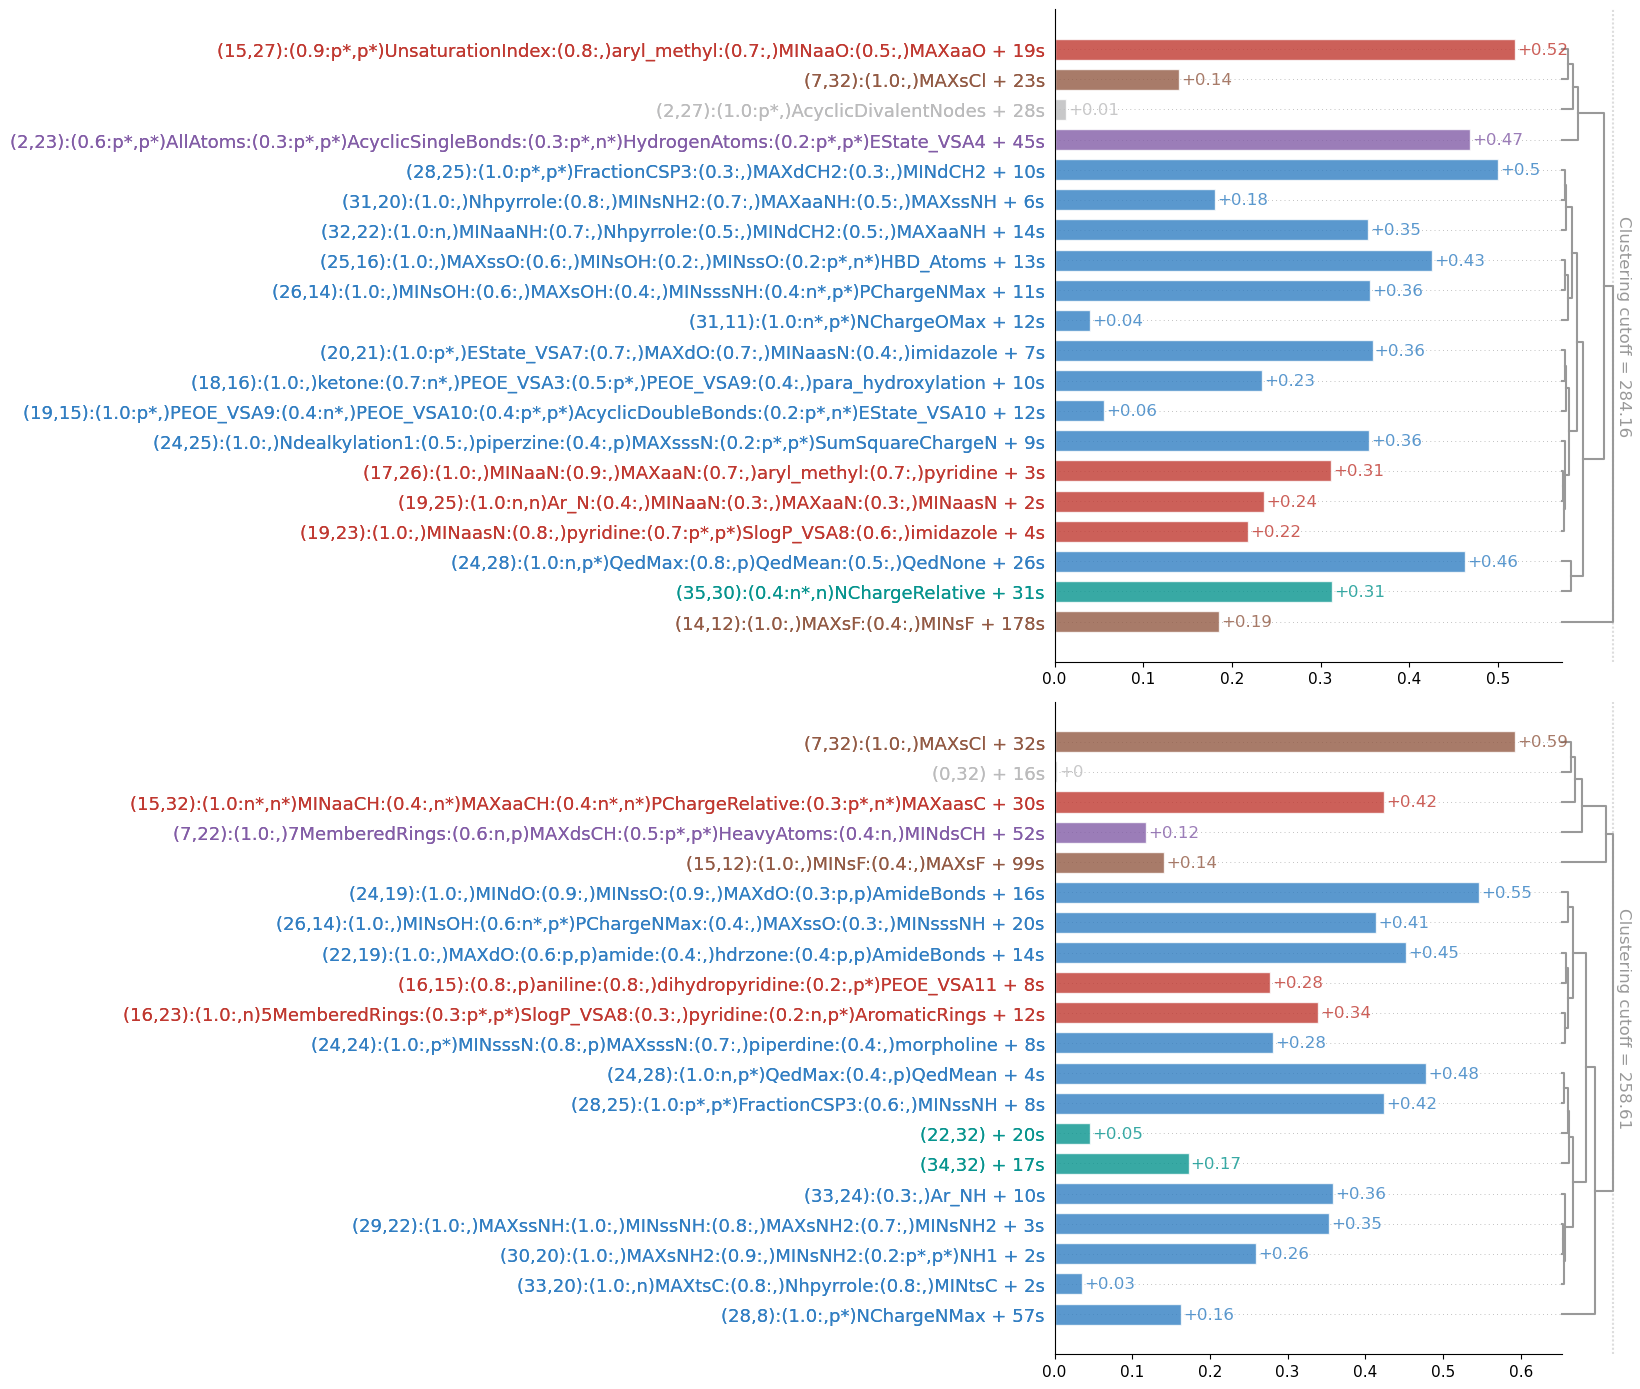

In [13]:
def print_tree(obj, indent=0):
    print(' ' * indent + str(obj))
    for child in obj.get_children():
        print_tree(child, indent+2)

# Start from figure


fig, (ax0, ax1) = plt.subplots(2,1,figsize=(20,14))
fun4(shap_sub_abs,corr,'SUB',display=20,num=4,exp=2.99,clu_type='ward',type_id=0,ax=ax0)
fun4(shap_inh_abs,corr,'INH',display=20,num=4,exp=2.99,clu_type='ward',type_id=1,ax=ax1)
positive_color = "#ca0020"
negative_color = "#92c5de"
default_pos_color = "#ff0051"
default_neg_color = "#008bfb"

colours=['#317EC2','#C03830','#06948E','#925A44','#825CA6','#BBBBBC']

mapping_list=[{
    5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 18: 0,  # Group 0
    1: 1, 15: 1, 16: 1, 17: 1,                                             # Group 1
    19: 2,                                                                 # Group 2
    2: 3, 20: 3,                                                           # Group 3
    4: 4,                                                                  # Group 4
    3: 5                                                                   # Group 5
},{
    6: 0, 7: 0, 8: 0, 11: 0, 12: 0, 13: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0,  # Group 0
    3: 1, 9: 1, 10: 1,                                                       # Group 1
    14: 2, 15: 2,                                                            # Group 2
    1: 3, 5: 3,                                                              # Group 3
    4: 4,                                                                   # Group 4
    2: 5                                                                    # Group 5
}]

# print_tree(fig)

labels = [label.get_text() for label in ax0.get_yticklabels()]
modified_labels = [label[:-15] + 's' if len(label) > 15 else label for label in labels]
ax0.set_yticks(ax0.get_yticks())
ax0.set_yticklabels(modified_labels)
ax0.set_xlabel(None)

labels = [label.get_text() for label in ax1.get_yticklabels()]
modified_labels = [label[:-15] + 's' if len(label) > 15 else label for label in labels]
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels(modified_labels)
ax1.set_xlabel(None)

count=0
for fc in ax0.yaxis.get_children():
    if isinstance(fc,mpl.axis.YTick):
        for fcc in fc.get_children():
            if isinstance(fcc, plt.Text):
                num=(count//2)%20+1
                fcc.set_color(colours[mapping_list[0][num]])
                count+=1
                # print(fcc,(count+1)//2)

count=0
for fc in ax1.yaxis.get_children():
    if isinstance(fc,mpl.axis.YTick):
        for fcc in fc.get_children():
            if isinstance(fcc, plt.Text):
                num=(count//2)%20+1
                fcc.set_color(colours[mapping_list[1][num]])
                count+=1
                # print(fcc,mapping_list[1][(count+1)//2])

for i,fc in enumerate(plt.gcf().get_children()):
    # Ignore last Rectangle
    for j,fcc in enumerate(fc.get_children()[:-1]):
        if j>39:
            continue
        # print(fcc)
        if (isinstance(fcc, mpl.patches.Rectangle)):
            # print(fcc,i,j%20)
            fcc.set_facecolor(colours[mapping_list[i-1][j%20+1]])
            # fcc.set_alpha(0.5)
        elif (isinstance(fcc, plt.Text)):
            # print(fcc,i,j%20)
            fcc.set_color(colours[mapping_list[i-1][j%20+1]])
        fcc.set_alpha(0.8)

plt.tight_layout(rect=(0.12, 0, 1, 1))
plt.savefig('image/'+'shap_summary_bar.png',bbox_inches='tight',transparent=True)
plt.show()

In [14]:
indices=np.zeros(len(feat_name),dtype=np.int_)
indices_inv=np.zeros(len(feat_name),dtype=np.int_)
for idict in indices_list:
    ind,idx = idict['indices'],idict['idx']
    indices[idx] = ind
    indices_inv[ind] = idx

In [15]:
heatmap_inh=np.zeros(37*37)
heatmap_sub=np.zeros(37*37)
for i,ind in enumerate(indices_inv):
    heatmap_inh[i]=shap_inh_abs.values[ind]
    heatmap_sub[i]=shap_sub_abs.values[ind]
# heatmap_inh=(heatmap_inh-heatmap_inh.min())/heatmap_inh.max()
# heatmap_sub=(heatmap_sub-heatmap_sub.min())/heatmap_sub.max()
heatmap_inh=heatmap_inh.reshape(37,37)
heatmap_sub=heatmap_sub.reshape(37,37)

In [16]:
heat_inh=pd.DataFrame(heatmap_inh)
heat_sub=pd.DataFrame(heatmap_sub)

In [17]:
print(heatmap_inh.sum(),heatmap_sub.sum())

1.1294898719322792 1.2121846538944197


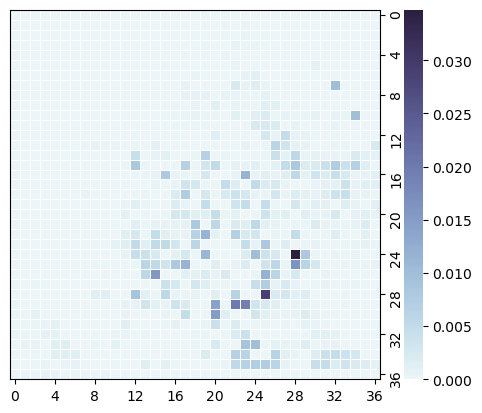

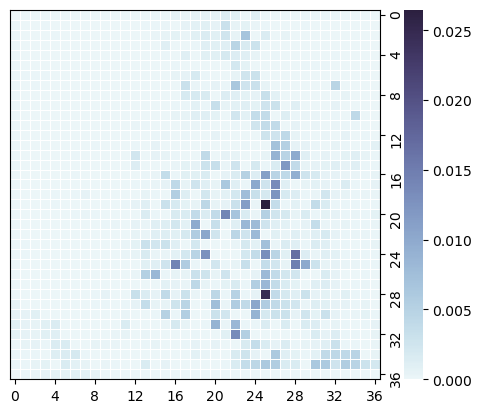

In [18]:
ax = sns.heatmap(heat_inh,
                 linewidth=.5,
                 cmap=sns.color_palette("ch:s=.25,rot=-.25,l=0.95", as_cmap=True),
                 cbar=True,
                 square=True,
)

ax.xaxis.set_ticks(np.arange(0.5, 37, 4))
ax.yaxis.set_ticks(np.arange(0.5, 37, 4))
ax.yaxis.tick_right()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.8)
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
ax.figure.savefig('./image/heatmap_INH.png',bbox_inches='tight',transparent=True)
plt.show()
ax = sns.heatmap(heat_sub,
                 linewidth=.5,
                 cmap=sns.color_palette("ch:s=.25,rot=-.25,l=0.95", as_cmap=True),
                 cbar=True,
                 square=True,
)

ax.xaxis.set_ticks(np.arange(0.5, 37, 4))
ax.yaxis.set_ticks(np.arange(0.5, 37, 4))
ax.yaxis.tick_right()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.8)

ax.figure.savefig('./image/heatmap_SUB.png',bbox_inches='tight',transparent=True)
plt.show()

In [19]:
def view_depend(shap_inh,corr,feat,ax=None):
    tmp=deepcopy(process(shap_inh))

    X=tmp.data
    y=tmp.values

    ind=np.arange(X.shape[0])
    idx=order_feat[feat]
    
    X_ = X[:,idx]
    y_ = y[:,idx]

    print(corr[feat],'index:',idx)
    
    if ((attr[feat] == 'Estate' and not feat.startswith('N')) or attr[feat] == 'MOE'):
        ind = np.where(abs(X_)>1e-4)[0]
        print()
    
    mask_ = np.array([ s not in ind for s in np.arange(X.shape[0]) ])
    ind_ = np.arange(X.shape[0])[mask_]

    if ax is None:
        shap.plots.scatter(
            tmp[ind,feat],
            show=False,
            dot_size=5,
            # xmin=min(tmp[:,feat].data)-0.05*(max(tmp[:,feat].data)-min(tmp[:,feat].data)),
            # xmax=max(tmp[:,feat].data)+0.05*(max(tmp[:,feat].data)-min(tmp[:,feat].data)),
        )
        plt.scatter(tmp[ind_,feat].data,tmp[ind_,feat].values,c='r',s=5)
        plt.show()
    else:
        shap.plots.scatter(
            tmp[ind,feat],
            show=False,
            dot_size=5,
            # xmin=min(tmp[:,feat].data)-0.05*(max(tmp[:,feat].data)-min(tmp[:,feat].data)),
            # xmax=max(tmp[:,feat].data)+0.05*(max(tmp[:,feat].data)-min(tmp[:,feat].data)),
            ax=ax,
        )
        ax.scatter(tmp[ind_,feat].data,tmp[ind_,feat].values,c='r',s=5,)
        ax.legend(title='', loc='lower left', labels=['Correlation coefficient p=%.2f'%(corr[feat])], fontsize="large", frameon=False)

task INH

Experiment 1 MolFractionCSP3
0.9822897740075106 index: 10

Experiment 2 NChargeRelative
-0.8890857750126527 index: 764

Experiment 3 PChargeRelative
-0.997859619015714 index: 765

Experiment 4 MolUnsaturationIndex
0.9389084887394286 index: 12

task SUB

Experiment 1 MolFractionCSP3
0.9409470952363321 index: 10

Experiment 2 NChargeRelative
-0.976262177660337 index: 764

Experiment 3 PChargeRelative
-0.9781203191155351 index: 765

Experiment 4 MolUnsaturationIndex
0.9894211963275498 index: 12



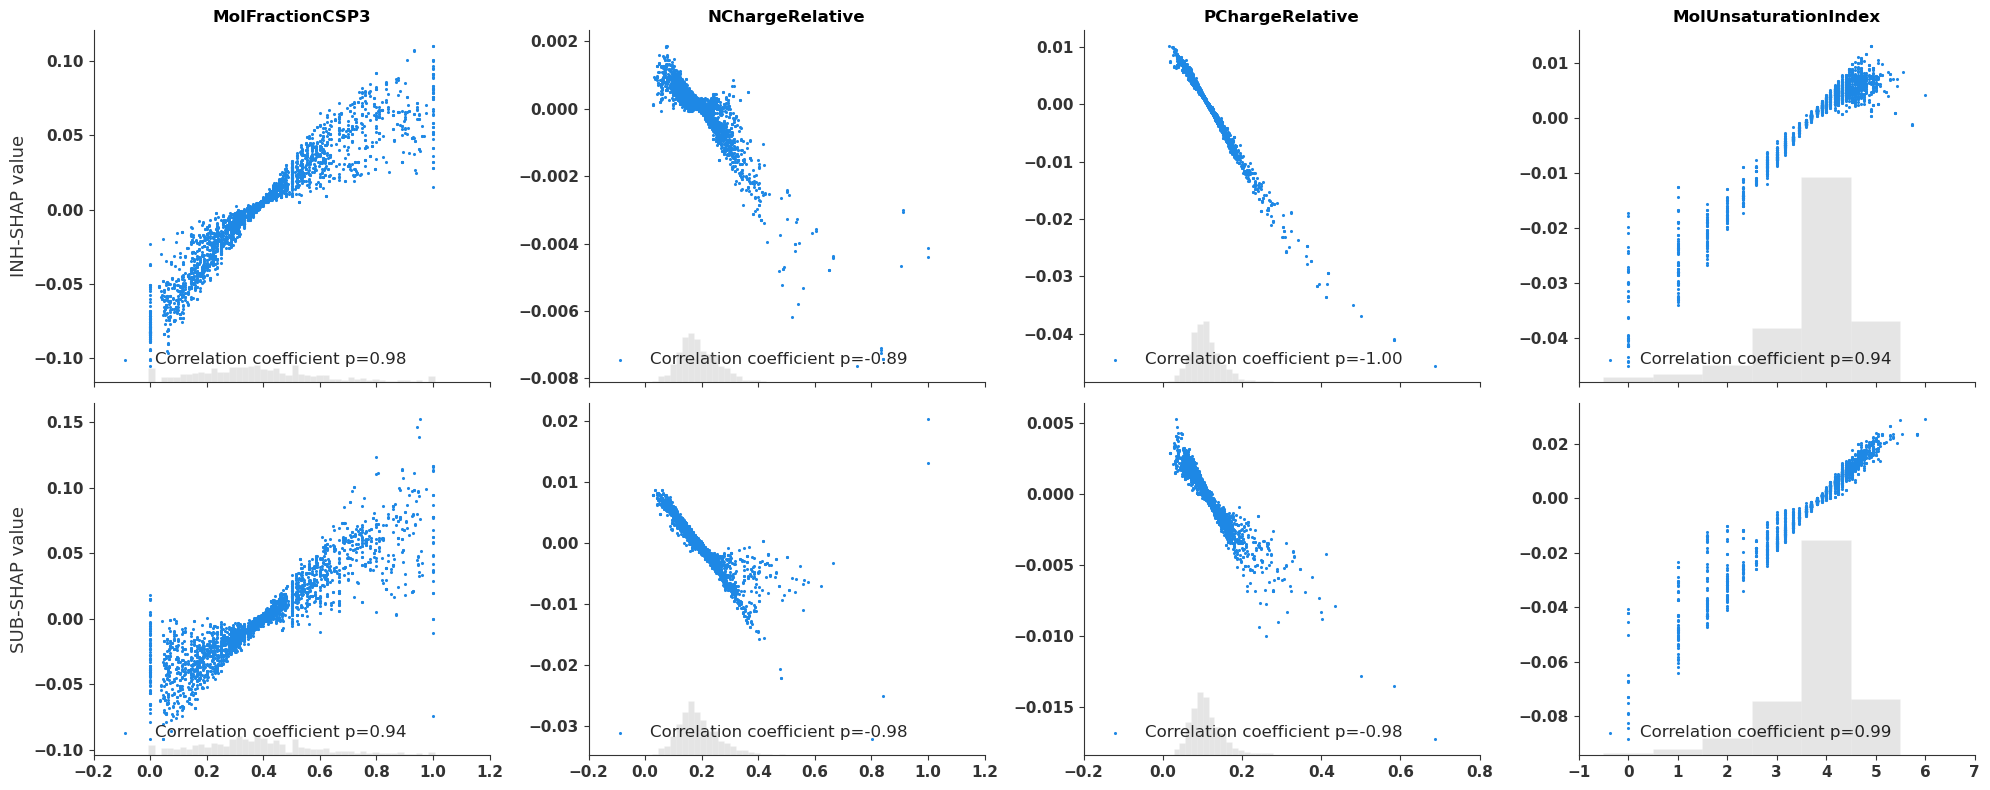

task INH

Experiment 1 MolQedWeightsMax
0.987118171421198 index: 6

Experiment 2 PChargeNMax
0.9647999763531387 index: 784

Experiment 3 NChargeOMax
0.9164618443547901 index: 779

Experiment 4 NChargeNMax
0.9223101825352595 index: 780

task SUB

Experiment 1 MolQedWeightsMax
-0.880227019768402 index: 6

Experiment 2 PChargeNMax
-0.9700230919478676 index: 784

Experiment 3 NChargeOMax
-0.9466386026096644 index: 779

Experiment 4 NChargeNMax
0.6591560726289976 index: 780



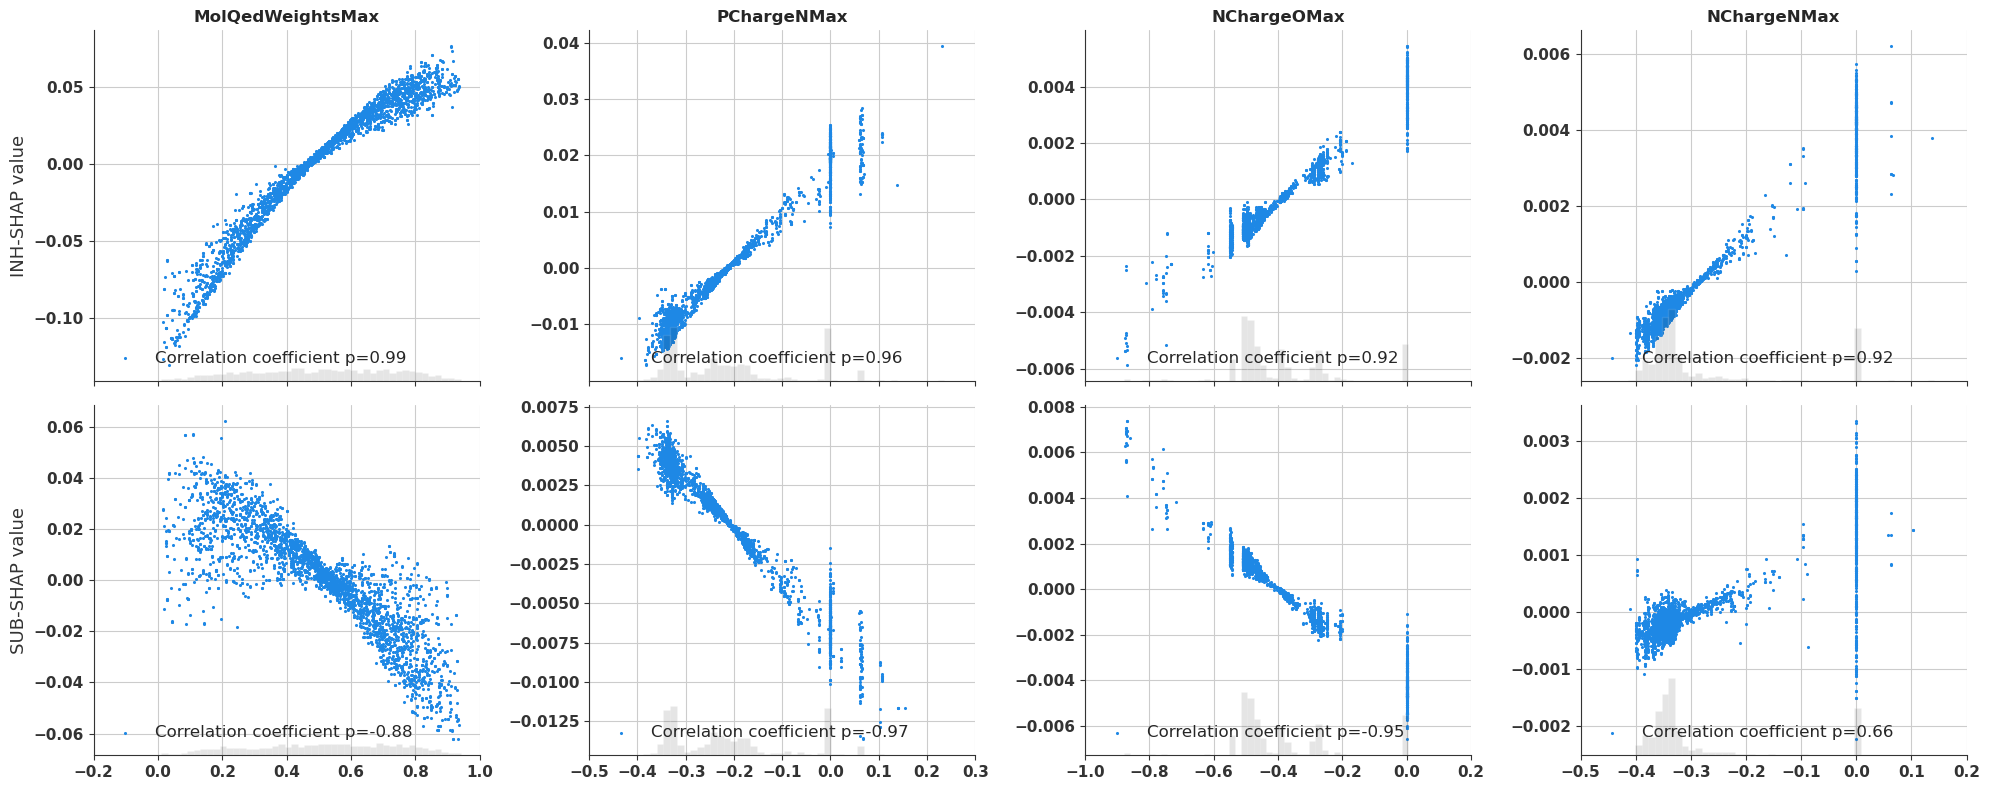

task INH

Experiment 1 NumHydrogenBondAcceptorSites
-0.9918763887686805 index: 58

Experiment 2 NumHydrogenBondDonorSites
-0.9645409740479509 index: 60

Experiment 3 MAXaasC
-0.9949901577215196 index: 911


Experiment 4 MAXaaCH
-0.964606163467021 index: 906


task SUB

Experiment 1 NumHydrogenBondAcceptorSites
0.9278890327783369 index: 58

Experiment 2 NumHydrogenBondDonorSites
0.1799127162517925 index: 60

Experiment 3 MAXaasC
0.9729029811154137 index: 911


Experiment 4 MAXaaCH
-0.31780036535671047 index: 906




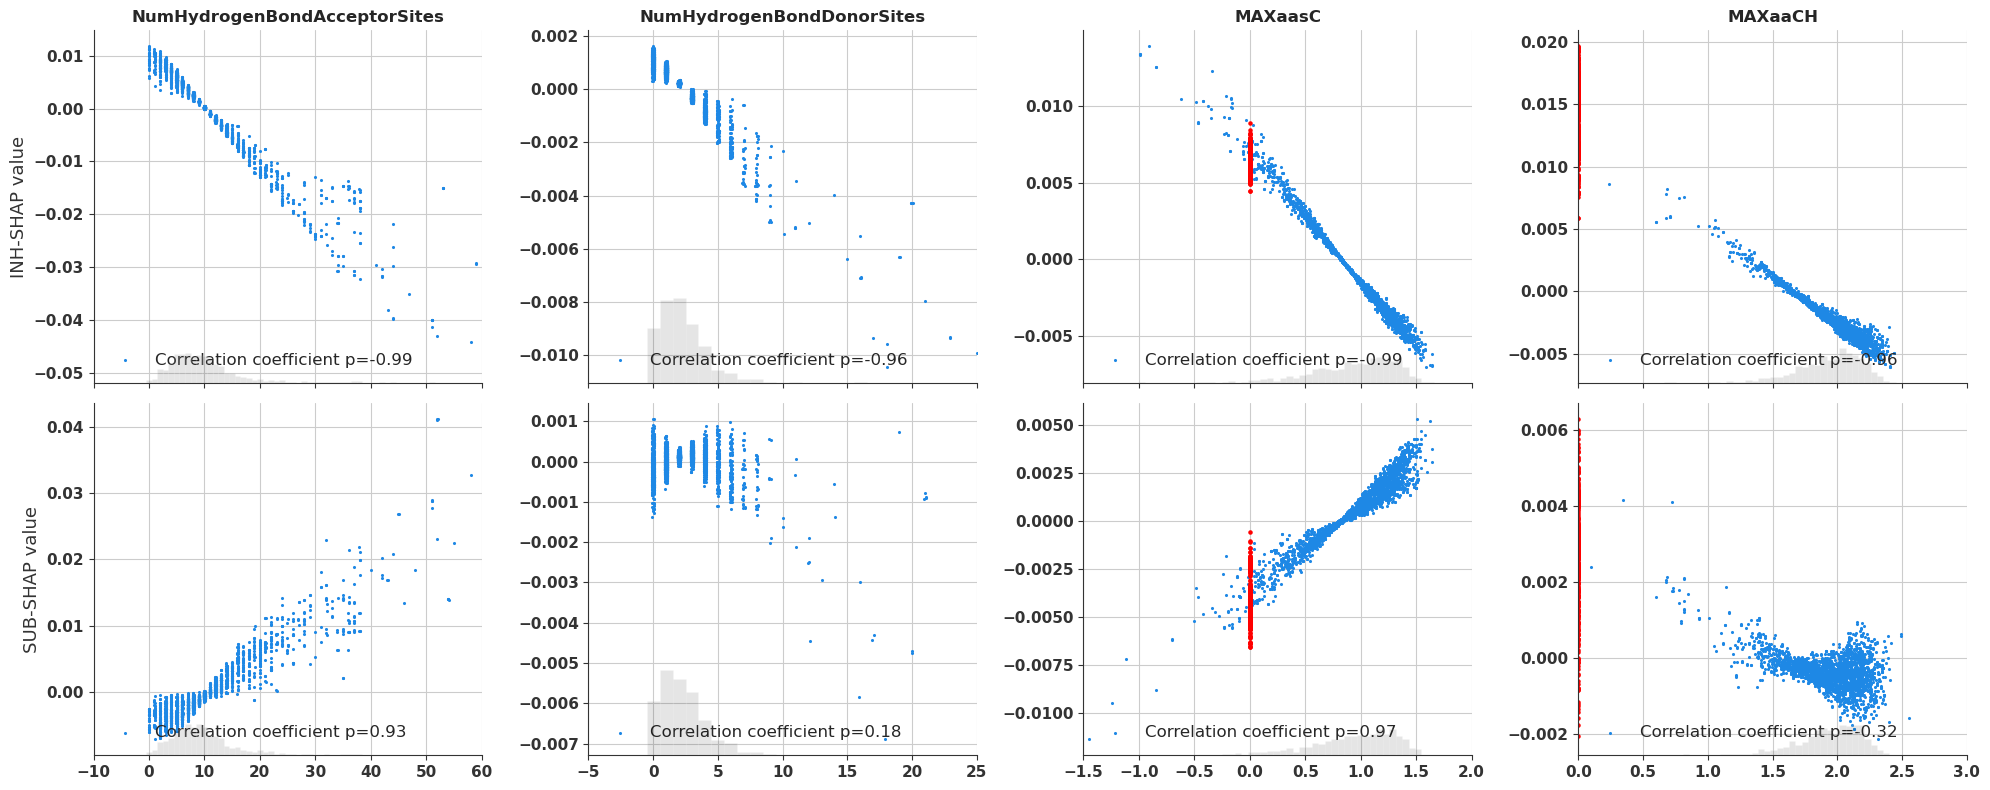

In [20]:
def get_SHAP_plot(allo_com,name):
    fig, ax_list = plt.subplots(2,len(allo_com),figsize=(20,8),sharex='col')
    sns.set_style("whitegrid")
    for col,task in enumerate(['INH','SUB']):
        print('task '+task)
        print()
        for num in range(len(allo_com)):
            cur_ax=ax_list[col,num]
            print('Experiment '+str(num+1),allo_com[num])
            view_depend(shap_inh if col==0 else shap_sub,inh_corr if col==0 else sub_corr,allo_com[num],cur_ax)
            print()
            
            # if col==0 or num!=0:
            #     cur_ax.get_legend().remove()
            # else:
            #     sns.move_legend(ax, "lower left")
    
            if col==0:
                ctitle=allo_com[num]
                cur_ax.set_title(ctitle, weight='bold')
    
            # ax.set_ylabel('Value (%)')
            cur_ax.set_xlabel(None)
            if num==0:
                if col==0:
                    cur_ax.set_ylabel('INH-SHAP value')
                else:
                    cur_ax.set_ylabel('SUB-SHAP value')
            else:
                cur_ax.set_ylabel(None)
    
            if col==1:
                cur_ax.set_xticks(cur_ax.get_xticks())
                cur_ax.set_xticklabels(cur_ax.get_xticklabels(), weight='bold')
            else:
                cur_ax.tick_params(axis='x', labelbottom=False)
        
            cur_ax.set_yticklabels(cur_ax.get_yticklabels(), weight='bold')
            # cur_ax.set_xticks(cur_ax.get_xticks())
            # cur_ax.set_xticklabels(cur_ax.get_xticklabels(), rotation=40, weight='bold')
    
    plt.tight_layout()
    plt.savefig('./image/'+name+'.png',bbox_inches='tight',transparent=True)
    plt.show()

allo_com=['MolFractionCSP3','NChargeRelative','PChargeRelative','MolUnsaturationIndex']
get_SHAP_plot(allo_com,'SHAPPlotCom')

allo_diff=['MolQedWeightsMax','PChargeNMax','NChargeOMax','NChargeNMax']
get_SHAP_plot(allo_diff,'SHAPPlotDiff1')

allo_diff=['NumHydrogenBondAcceptorSites','NumHydrogenBondDonorSites','MAXaasC','MAXaaCH']
get_SHAP_plot(allo_diff,'SHAPPlotDiff2')